In [2]:
from ha_nii_fit import Ha_NII
from fit_routine import WLAX, lines, hamod1, hamod2, chisq, c, z, vel2lambda, lambda2vel
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import curve_fit
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
hdul1 = fits.open("../cube_rebin.fits")
head = hdul1[0].header
cubehdu = hdul1[0]
cubehead = cubehdu.header
cube = cubehdu.data


hdu = fits.open("../varc_rebin.fits")
varc = hdu[0].data

hdul2 = fits.open("../basespec_smoothed.fits")
basespec = hdul2[0].data

ha_nii = Ha_NII('Ha+NII', lines['Ha+NII'][0], lines['Ha+NII'][1], lines['Ha+NII'][2], cube, varc, basespec)

In [6]:
ha_nii.load_fitcubes("/Users/gordonwongyl/Documents/Astronomy/BCG Line Emission with MUSE Data/line_fit/Ha_NII_fit/ha_nii_fit_v4.fits")

In [4]:
ha_nii.lranges

(6570.719841238035, 6694.987618686441)

In [ ]:
PIXELS = [(153,89), (153,87), (168,116), (174,121)]
MOD2 = [(114,121), (132, 109), (166,135), (169,118), (148,148)]
ha_nii.plot_eval(PIXELS+MOD2, save=False, fname="Ha_NII_mod_compare")

In [ ]:
# version 1: Comined Fit
quickrej = 0
snrrej = 0
runerr = 0
mod2 = np.zeros((ha_nii.cube_x, ha_nii.cube_y))
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
l_lranges = ha_nii.lranges

stime = time.time()
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):

        fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej += 1
            ha_nii.rejcube[0, i, j] = 1
            continue

        try:
            popt1, pcov1 = curve_fit(hamod1, l_wlax, fit_spec[mask], p0=[2e3, 2e3, obs_0, 2.3],
                                bounds=([0, 0, l_lranges[0], 0], [1.5e4, 1.5e4, l_lranges[1], 50]), absolute_sigma=True, sigma=errspec[mask])

            uncertainty1 = np.sqrt(np.diagonal(np.abs(pcov1))[0:4])
            snr_nii = popt1[0] / uncertainty1[0]
            snr_ha = popt1[1] / uncertainty1[1]

            chi = chisq(hamod1, l_wlax, fit_spec[mask], errspec[mask], popt1)
            if chi <= 1.2:

                ha_nii.fitcube[:4, i, j] = np.nan
                ha_nii.fiterrcube[:4, i, j] = np.nan
                ha_nii.fitcube[4:8, i, j] = popt1[0:4]

                ha_nii.fitcube[10:, i, j] = [snr_nii, snr_ha]

            else:

                popt2, pcov2 = curve_fit(hamod2, l_wlax, fit_spec[mask], p0=[176, 75, obs_0, 20, 176, 75, obs_0-10, 20],
                                            bounds=([0, 0, l_lranges[0], 0, 0, 0, l_lranges[0], 0], [1e5, 1e5, l_lranges[1], 50, 1e5, 1e5, l_lranges[1], 50]))
                uncertainty2 = np.sqrt(np.diagonal(pcov2[0:8]))

                snr_ha_1 = popt2[1] / uncertainty2[1]
                snr_ha_2 = popt2[5] / uncertainty2[5]
                vel_snr = np.abs(popt2[6]- popt2[2]) / np.sqrt(uncertainty2[6]**2 + uncertainty2[2]**2)

                if snr_ha_1 > 3. and snr_ha_2 > 3. and vel_snr > 3.:
                    ha_nii.fitcube[:8,i,j] = popt2
                    ha_nii.fiterrcube[:8, i, j] = uncertainty2

                    snr_nii_1 = popt2[0] / uncertainty2[0]
                    snr_nii_2 = popt2[4] / uncertainty2[4]

                    ha_nii.fitcube[8:, i, j] = [snr_nii_1, snr_ha_1, snr_nii_2, snr_ha_2]
                    mod2[i,j] = 1
                

                elif snr_ha > 3. and snr_nii > 3.:
                    ha_nii.fitcube[:4, i, j] = np.nan
                    ha_nii.fiterrcube[:4, i, j] = uncertainty1
                    ha_nii.fitcube[4:8, i, j] = popt1[0:4]

                    ha_nii.fitcube[10:, i, j] = [snr_nii, snr_ha]
                else:
                    snrrej += 1
                    ha_nii.set_to_nan(i, j)
                    ha_nii.fitcube[10:, i, j] = [snr_nii, snr_ha]
                    ha_nii.rejcube[1, i, j] = 1


        except (RuntimeError, ValueError):
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1

print(quickrej)
print(snrrej)
print(runerr)
print(np.count_nonzero(mod2))
print(time.time() - stime)


newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.fitcube[i])
                            for i in range(1, ha_nii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.fiterrcube[i])
              for i in range(ha_nii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/ha_nii_fit_v4.fits', overwrite=True)

rejhdus = fits.PrimaryHDU(ha_nii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(ha_nii.rejcube[i])
                              for i in range(1, ha_nii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Ha_NII_fit/ha_nii_rej_v4.fits', overwrite=True)

detectedimg = np.nan_to_num(ha_nii.fitcube[4])
snrrejimg = np.nan_to_num(ha_nii.rejcube[1])
evalimg = detectedimg + snrrejimg 

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
chihdu = [fits.ImageHDU(mod2)]
hdul3 = fits.HDUList([evalhdus] + chihdu)
hdul3.writeto('../Ha_NII_fit/ha_nii_eval_v4.fits', overwrite= True)




In [ ]:
# mod1 Fit only (no rej)
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
l_lranges = ha_nii.lranges
ha_ranges = (vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) - 700, ha_nii.rest[1]), 
             vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) + 700, ha_nii.rest[1]))

stime = time.time()
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):

        fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej += 1
            ha_nii.rejcube[0, i, j] = 1
            continue

        try:
            popt1, pcov1 = curve_fit(hamod1, l_wlax, fit_spec[mask], p0=[2e3, 2e3, obs_0, 2.7],
                                bounds=([0, 0, ha_ranges[0], 0], [1.5e5, 1.5e5, ha_ranges[1], 20]), absolute_sigma=True, sigma=errspec[mask])

            uncertainty1 = np.sqrt(np.diagonal(np.abs(pcov1))[0:4])
            snr_nii = popt1[0] / uncertainty1[0]
            snr_ha = popt1[1] / uncertainty1[1]

            chi = chisq(hamod1, l_wlax, fit_spec[mask], errspec[mask], popt1)


            ha_nii.fitcube[:4, i, j] = np.nan
            ha_nii.fiterrcube[:4, i, j] = np.nan
            ha_nii.fitcube[4:8, i, j] = popt1[0:4]

            ha_nii.fitcube[8:11, i, j] = [snr_nii, snr_ha, chi]
            ha_nii.fitcube[11:, i, j] = np.nan


        except (RuntimeError, ValueError):
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)


newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.fitcube[i])
                            for i in range(1, ha_nii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.fiterrcube[i])
              for i in range(ha_nii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/ha_nii_rebin_fit_mod1.fits', overwrite=True)

rejhdus = fits.PrimaryHDU(ha_nii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(ha_nii.rejcube[i])
                              for i in range(1, ha_nii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Ha_NII_fit/ha_nii_rebin_rej_mod1.fits', overwrite=True)

detectedimg = np.nan_to_num(ha_nii.fitcube[4])
snrrejimg = np.nan_to_num(ha_nii.rejcube[1])
evalimg = detectedimg + snrrejimg 

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Ha_NII_fit/ha_nii_rebin_eval_mod1.fits', overwrite=True)




In [ ]:
# mod2 fit only (no rej)
quickrej = 0
snrrej = 0
runerr = 0
obs_0 = ha_nii.obs[1]
mask = (ha_nii.lranges[0] < ha_nii.wlax) & (ha_nii.wlax < ha_nii.lranges[1])
l_wlax = ha_nii.wlax[mask]
l_lranges = ha_nii.lranges
ha_ranges = (vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) - 700, ha_nii.rest[1]), 
             vel2lambda(lambda2vel(ha_nii.obs[1], ha_nii.rest[1]) + 700, ha_nii.rest[1]))

stime = time.time()
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):

        fit_spec, errspec = ha_nii.get_fit_spaxel(i, j)

        if type(fit_spec) == type(None):
            quickrej += 1
            ha_nii.rejcube[0, i, j] = 1
            continue

        try:

            popt2, pcov2 = curve_fit(hamod2, l_wlax, fit_spec[mask], p0=[176, 75, obs_0, 20, 176, 75, obs_0+7, 1.5],
                                        bounds=([0, 0, ha_ranges[0], 0, 0, 0, ha_ranges[0], 0], [1e5, 1e5, ha_ranges[1], 50, 1e5, 1e5, ha_ranges[1], 10]))
            uncertainty2 = np.sqrt(np.diagonal(pcov2[0:8]))
           

            snr_ha_1 = popt2[1] / uncertainty2[1]#
            snr_ha_2 = popt2[5] / uncertainty2[5]
            vel_snr = np.abs(popt2[6]- popt2[2]) / np.sqrt(uncertainty2[6]**2 + uncertainty2[2]**2)
            chi = chisq(hamod2, l_wlax, fit_spec[mask], errspec[mask], popt2)
            snr_nii_1 = popt2[0] / uncertainty2[0]#
            snr_nii_2 = popt2[4] / uncertainty2[4]


            ha_nii.fitcube[:8,i,j] = popt2
            ha_nii.fiterrcube[:8, i, j] = uncertainty2
            ha_nii.fitcube[8:, i, j] = [snr_nii_1, snr_ha_1, snr_nii_2, snr_ha_2, vel_snr, chi]
            

        except (RuntimeError, ValueError):
            runerr += 1
            ha_nii.set_to_nan(i, j)
            ha_nii.rejcube[2, i, j] = 1

print(quickrej)
print(snrrej)
print(runerr)
print(time.time() - stime)


newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.fitcube[i])
                            for i in range(1, ha_nii.fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.fiterrcube[i])
              for i in range(ha_nii.fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/ha_nii_rebin_fit_mod2_3.fits', overwrite=True)

rejhdus = fits.PrimaryHDU(ha_nii.rejcube[0], header=newhead)
otherrejhdus = [fits.ImageHDU(ha_nii.rejcube[i])
                              for i in range(1, ha_nii.rejcube.shape[0])]
hdul2 = fits.HDUList([rejhdus]+otherrejhdus)
hdul2.writeto('../Ha_NII_fit/ha_nii_rebin_rej_mod2_3.fits', overwrite=True)

detectedimg = np.nan_to_num(ha_nii.fitcube[4])
snrrejimg = np.nan_to_num(ha_nii.rejcube[1])
evalimg = detectedimg + snrrejimg 

evalhdus = fits.PrimaryHDU(evalimg, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Ha_NII_fit/ha_nii_rebin_eval_mod2_3.fits', overwrite=True)




In [4]:
ha_nii.load_2fitcubes("../Ha_NII_fit/ha_nii_rebin_fit_mod1.fits", "../Ha_NII_fit/Combine/ha_nii_rebin_fit_mod2_2_sort_flux.fits")

In [5]:
def select(i, j):
    self = ha_nii
    self.fitcube = np.zeros((14, self.cube_x, self.cube_y))
    self.fiterrcube = np.zeros((8 ,self.cube_x, self.cube_y))
    
    popt1 = self.mod1_fitcube[4:8, i, j]
    snr_nii = self.mod1_fitcube[8, i, j]
    snr_ha = self.mod1_fitcube[9, i, j]
    chi1 = self.mod1_fitcube[10, i, j]

    popt2 = self.mod2_fitcube[0:8, i, j]
    snr_nii_1 = self.mod2_fitcube[8, i, j].copy()
    snr_ha_1 = self.mod2_fitcube[9, i, j].copy()
    snr_nii_2 = self.mod2_fitcube[10, i, j].copy()
    snr_ha_2 = self.mod2_fitcube[11, i, j].copy()
    vel_snr = self.mod2_fitcube[12, i, j]
    chi2 = self.mod2_fitcube[13, i, j]
    nii_ratio = popt2[0]/popt2[4] if popt2[0] < popt2[4] else popt2[4]/popt2[0]
    ha_ratio = popt2[1]/popt2[5] if popt2[1] < popt2[5] else popt2[5]/popt2[1]

    # Choose mod1 if well-fitted
    if snr_nii > 3. and snr_ha > 3. and chi1 <= 1.:
        self.mod2_fitcube[:,i,j] = np.nan
        self.mod2_fiterrcube[:,i,j] = np.nan
        return 1
    # Choose mod2 if the difference is significant
    if snr_nii_1 > 3. and snr_ha_1 > 3. and snr_nii_2 > 3. and snr_ha_2 > 3. and vel_snr > 3. and chi2 < chi1 and nii_ratio > 0.05 and ha_ratio > 0.05:

        self.mod1_fitcube[:,i,j] = np.nan
        self.mod1_fiterrcube[:,i,j] = np.nan 
            

        return 2
    elif snr_nii > 3. and snr_ha > 3.:
        self.mod2_fitcube[:,i,j] = np.nan
        self.mod2_fiterrcube[:,i,j] = np.nan
        return 1
    else:
        self.mod1_fitcube[:,i,j] = np.nan
        self.mod1_fiterrcube[:,i,j] = np.nan 
        self.mod2_fitcube[:,i,j] = np.nan
        self.mod2_fiterrcube[:,i,j] = np.nan
        return 0
    ...

select_img = np.full((ha_nii.cube_x, ha_nii.cube_y), np.nan)
for i in tqdm(range(ha_nii.cube_x), smoothing=1):
    for j in range(ha_nii.cube_y):
       select_img[i,j] = select(i,j)

#Save the 2 cubes
newwcs = WCS(cubehead, naxis=2)
newhead = newwcs.to_header()
prihdu = fits.PrimaryHDU(ha_nii.mod1_fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.mod1_fitcube[i])
                            for i in range(1, ha_nii.mod1_fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.mod1_fiterrcube[i])
              for i in range(ha_nii.mod1_fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/Combine/ha_nii_rebin_fit_mod1_select_flux.fits', overwrite=True)

prihdu = fits.PrimaryHDU(ha_nii.mod2_fitcube[0], header=newhead)
newsiihdus = [fits.ImageHDU(ha_nii.mod2_fitcube[i])
                            for i in range(1, ha_nii.mod2_fitcube.shape[0])]
siierrhdus = [fits.ImageHDU(ha_nii.mod2_fiterrcube[i])
              for i in range(ha_nii.mod2_fiterrcube.shape[0])]
hdul = fits.HDUList([prihdu] + newsiihdus + siierrhdus)
hdul.writeto('../Ha_NII_fit/Combine/ha_nii_rebin_fit_mod2_2_select_flux.fits', overwrite=True)


evalhdus = fits.PrimaryHDU(select_img, header=newhead)
hdul3 = fits.HDUList([evalhdus])
hdul3.writeto('../Ha_NII_fit/Combine/ha_nii_rebin_select_flux.fits', overwrite=True)

  0%|          | 0/65 [00:00<?, ?it/s]/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_37406/3773092075.py:18: RuntimeWarning: invalid value encountered in double_scalars
  nii_ratio = popt2[0]/popt2[4] if popt2[0] < popt2[4] else popt2[4]/popt2[0]
/var/folders/5m/d9qdltz940j7ch1nc4sgtqf00000gn/T/ipykernel_37406/3773092075.py:19: RuntimeWarning: invalid value encountered in double_scalars
  ha_ratio = popt2[1]/popt2[5] if popt2[1] < popt2[5] else popt2[5]/popt2[1]
100%|██████████| 65/65 [00:00<00:00, 181.33it/s]


In [1]:
MOD2 = [ (52,43), (49,42), (10,56), (37,43)]
ha_nii.plot_eval(MOD2, save=False, fname='Ha_NII_mod2_compare')

NameError: name 'ha_nii' is not defined

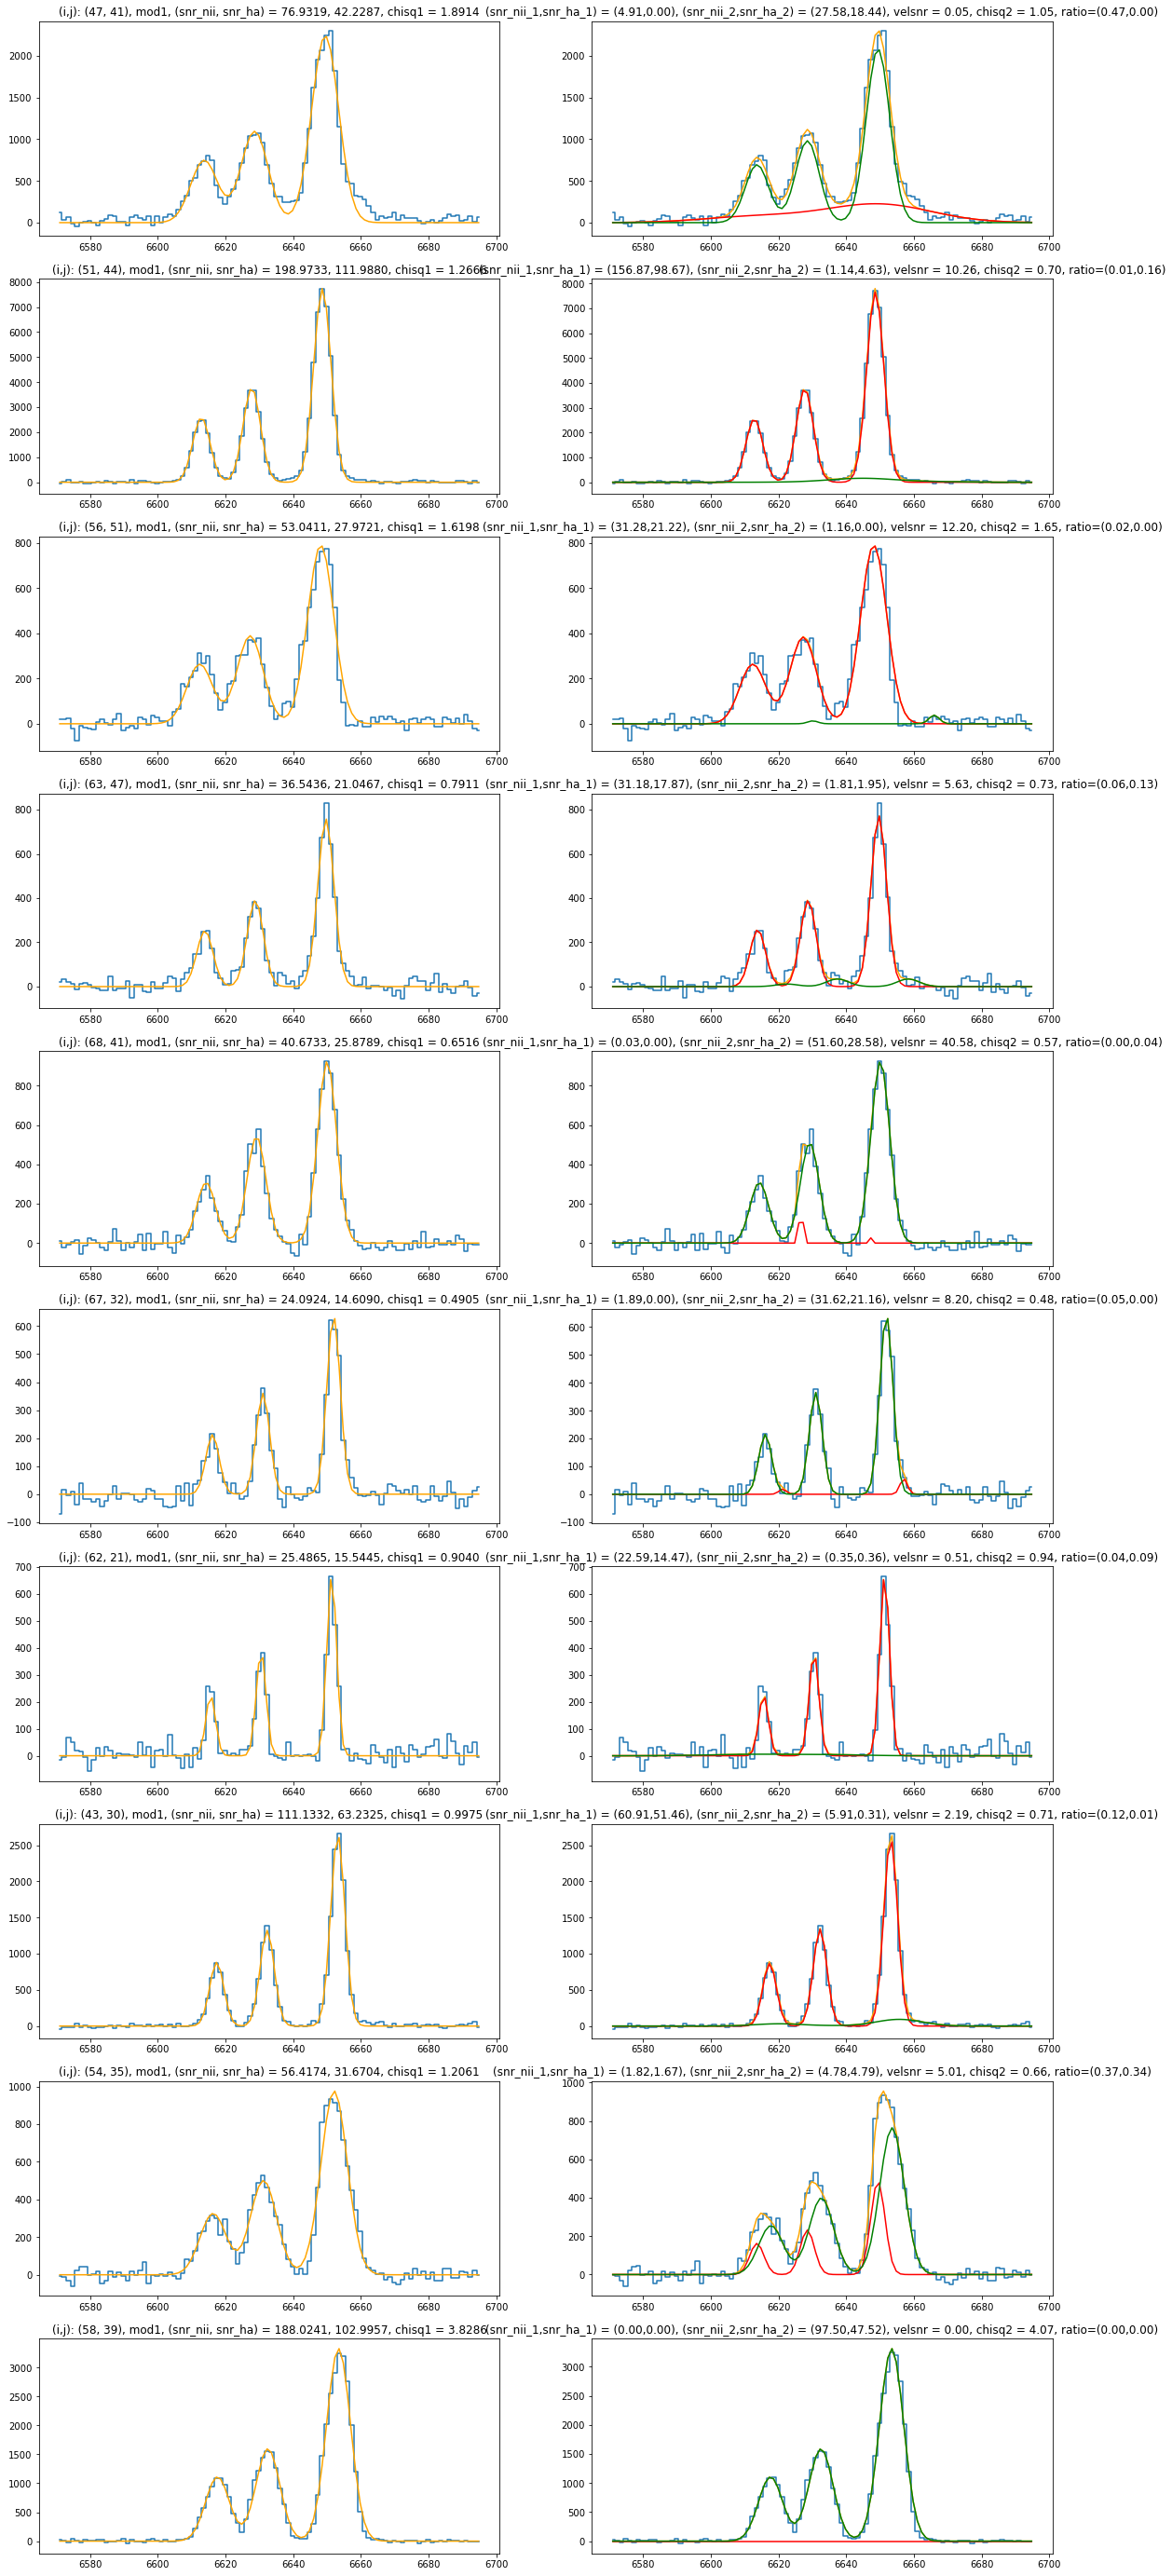

In [9]:
MOD1 = [(47,41), (51,44), (56,51), (63,47), (68,41), (67,32), (62,21), (43,30), (54,35), (58,39)]
ha_nii.plot_eval(MOD1, save=True, fname='Ha_NII_mod1_compare')

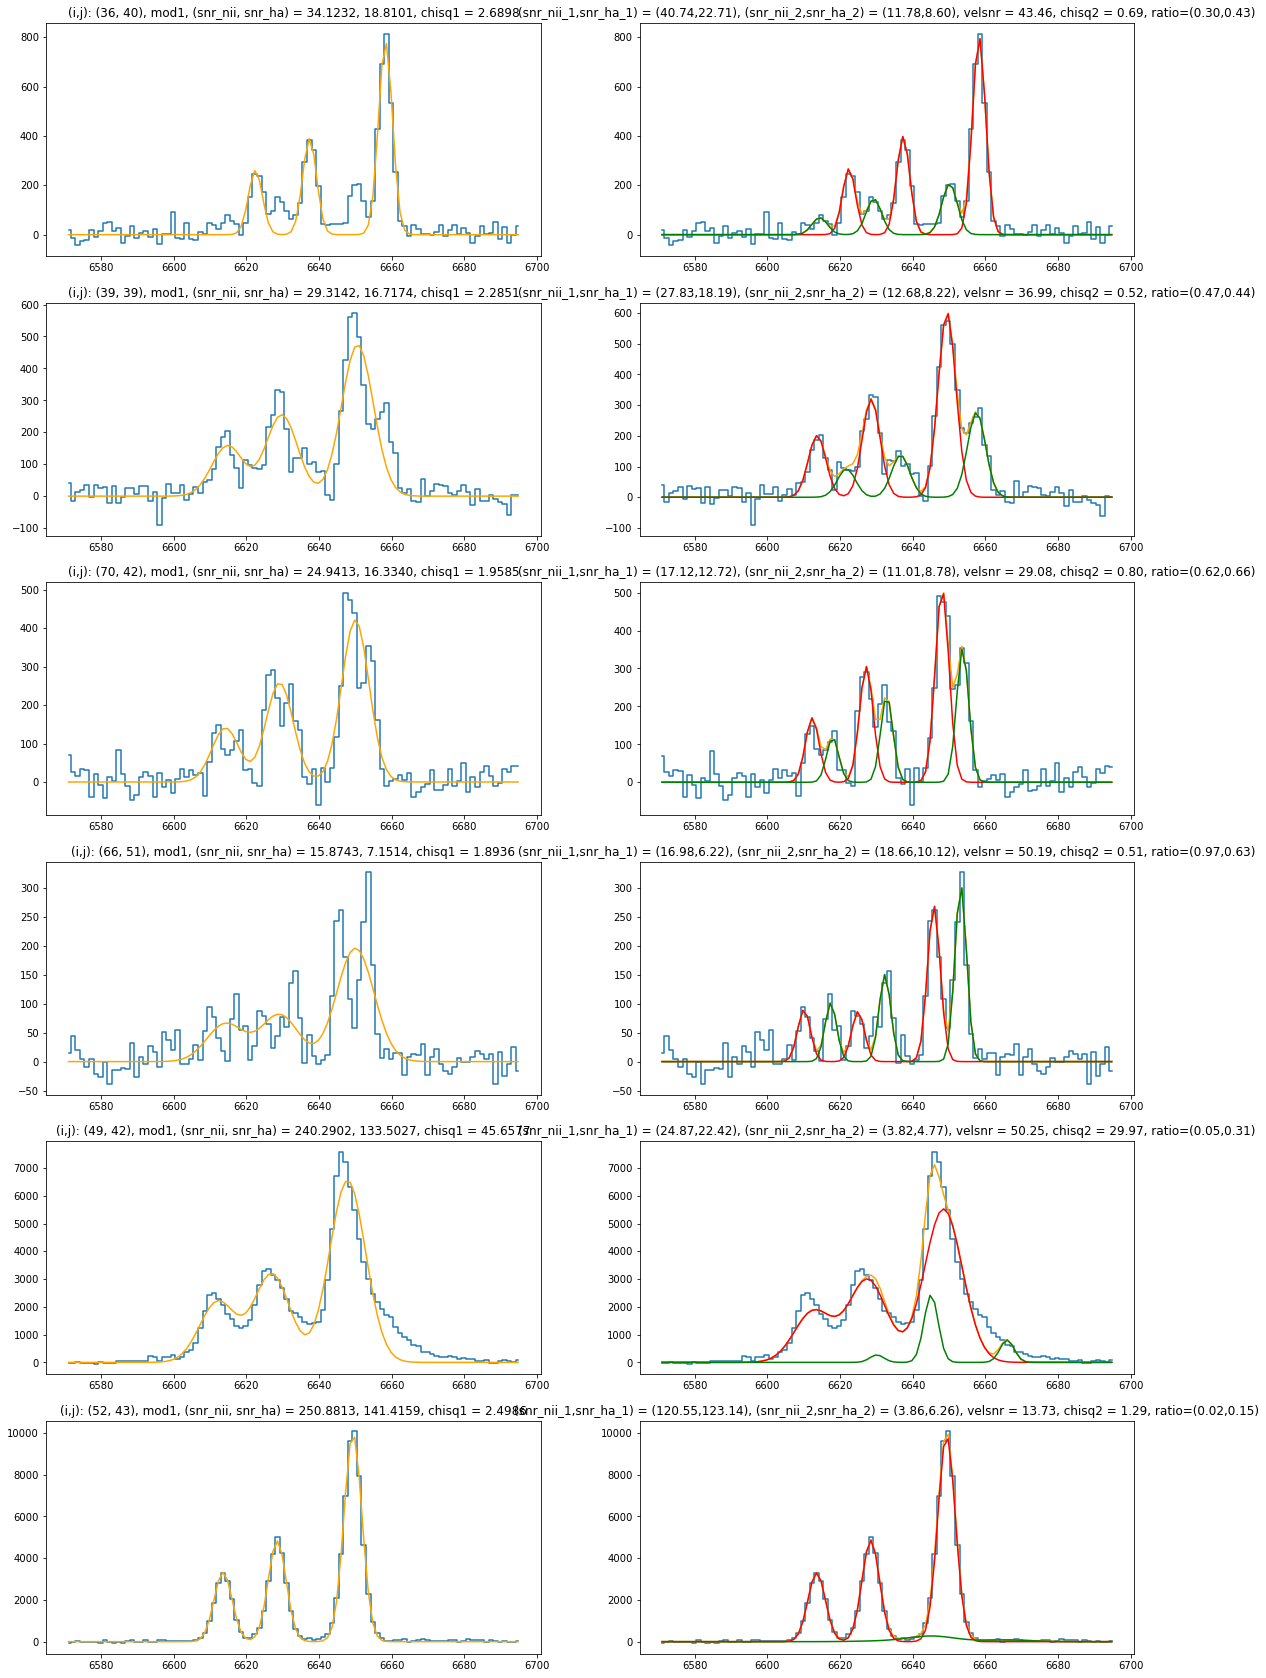

In [10]:
HIGH_VEL = [(36,40), (39,39), (70,42), (66,51), (49,42), (52,43)]
ha_nii.plot_eval(HIGH_VEL, save=True, fname='Ha_NII_HIGH_VEL')


In [ ]:
FLUX_REJ = [(38,36), (49,42), (52,43), (52,42), (51,32), (56,34), (57,45), (55,45), (66,41), (57,33)]
ha_nii.plot_eval(FLUX_REJ)

In [ ]:
RATIO_COMP = [(37,35),(39,41), (48,39), (54,44), (56,32), (66,42)]
ha_nii.plot_eval(RATIO_COMP)

In [ ]:
eval = fits.open("../Ha_NII_fit/select_2_4_comp.fits")[0].data
RATIO_EVAL = []
for i in range(eval.shape[0]):
    for j in range(eval.shape[1]):
        if eval[i,j] == -1:
            RATIO_EVAL.append((j+1, i+1))
ha_nii.plot_eval(RATIO_EVAL)